In [1]:
from preprocess.preprocess import *
import PARAMETERS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from confusion_matrix_pretty_print import print_confusion_matrix
from pathlib import Path

%matplotlib inline

PARAMETERS.LBP_METHOD = 'riu'
PARAMETERS.METHOD = 'get_pyramid_dataset'
PARAMETERS.INTERPOLATION_ALGORITHM = 'lanczos'
PARAMETERS.BALANCE = False
PARAMETERS.N_SCALES = 5
PARAMETERS.GRAY_INTENSITY = True
PARAMETERS.X2SCALE = True
PARAMETERS.FILE_EXTENSION = PARAMETERS.update_file_extension(PARAMETERS)
PARAMETERS.PLOT = False
PARAMETERS.DATASET = 'DRIVE'

pd.DataFrame({k: getattr(PARAMETERS, k) for k in VALID_PARAMETERS.keys()}, index=['Parameters']).head()

LBP_METHOD               METHOD INTERPOLATION_ALGORITHM  BALANCE  \
Parameters        riu  get_pyramid_dataset                 lanczos    False   

            N_SCALES  GRAY_INTENSITY  X2SCALE  
Parameters         5            True     True

### Resultado CV

F1-score 0.685426

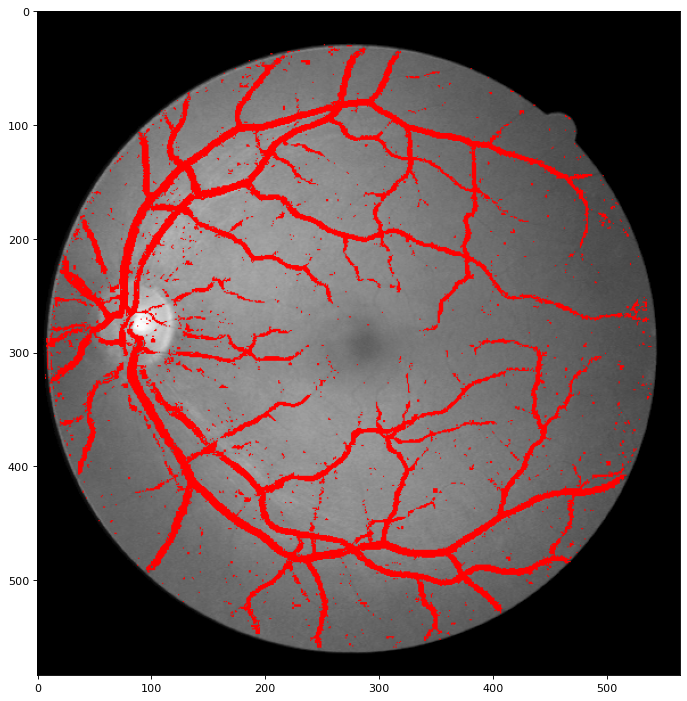

Accuracy score: 0.9292555186111174

F1 score: 0.7211952246541113

Confusion matrix:

     t/p      0     1 
        0 1141617 45928 
        1 50476 124686 
Sensivity: 0.7118324750802114
Specificity: 0.9613252550429668


(0.929, 0.721, 1141617, 45928, 50476, 124686)

In [2]:
from main import main
PARAMETERS.PLOT = True

main(lgb='Num', all_lbp=['riu', 'var'], plot_once=True, channels=(1, 2), recurrence=False)

In [3]:
import pickle

path = 'convolution/outputs/16477813803335671_300'
with open(f'{path}/population.pkl', 'rb') as handle:
    kernels = pickle.load(handle)

In [4]:
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
#k1, k2 = population[np.argmax(fitness), :9], population[np.argmax(fitness), 9:]

In [5]:
from os import listdir

PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
MASK_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/mask'
LABELS_PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/1st_manual'
n_kernels = 2
k_len = 9
k_size = 3

def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][:14]
    return [Preprocess.img_processing(np.asarray(Image.open(path).convert('RGB'))[:, :, 1])
            for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][:14]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES = load_images()
MASKS = load_masks()

conv_features = [pd.DataFrame(np.array(
    [cv2.filter2D(img, -1, individual[i*k_len:(i+1)*k_len].reshape((k_size, k_size)))[mask]
     for i in range(n_kernels)]
).T)
    for img, mask in zip(IMAGES, MASKS)]

conv_features = pd.concat(conv_features, axis=0)
conv_features.columns = ['k1', 'k2']
conv_features

k1   k2
0        48    7
1        53    7
2        57    6
3        39   23
4        35   26
...     ...  ...
226537   96  100
226538  104   96
226539   88  101
226540   85   70
226541   74   56

[3178299 rows x 2 columns]

In [86]:
import pandas as pd
import numpy as np

preprocess = Preprocess(height=608, width=576)
masks_path = f'../dataset/{PARAMETERS.DATASET}/training/mask/'
masks = sorted(os.listdir(masks_path))[:14]

n_pixels = {}
for i, mask_path in enumerate(masks):
    mask = preprocess.read_img(masks_path + mask_path)
    n_pixels[i] = np.sum(mask > 100)
    
pixel_ref = {}

for k, v in n_pixels.items():
    upper = np.sum(np.array(list(n_pixels.values()))[:k+1])
    pixel_ref[k] = (upper - n_pixels[k], upper)

cv_folds = {}

for i, j in enumerate(range(0, 14, 3)):
    cv_folds[i] = (pixel_ref[j][0], pixel_ref[min(j+2, 13)][1])
    
cv_folds

{0: (0, 681473),
 1: (681473, 1361653),
 2: (1361653, 2044115),
 3: (2044115, 2724019),
 4: (2724019, 3178299)}

In [87]:
from main import init_clf_and_fit
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

def test_features(features, verbose=False):
    f1_list = []
    acc_list = []
    if isinstance(features['y_train'], pd.Series):
        features['y_train'] = features['y_train'].to_frame()
    for k, v in cv_folds.items():
        PARAMETERS.MODEL_NAME = f"_cv_feat_sel_{k}"
        df_train_temp = pd.concat(
            [features['x_train'].iloc[cv_folds[0][0]:v[0], :],
             features['x_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        y_train_temp = pd.concat(
            [features['y_train'].iloc[cv_folds[0][0]:v[0], :],
             features['y_train'].iloc[v[1]:cv_folds[4][1], :]], axis=0)
        clf = init_clf_and_fit(
            df_train_temp, y_train_temp.values.ravel(), lgb='Num', parent_path='../models')
        y_predicted = clf.predict(features['x_train'].iloc[v[0]:v[1], :])
        acc = accuracy_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        acc_list.append(acc)
        f1 = f1_score(features['y_train'].iloc[v[0]:v[1], :], y_predicted)
        f1_list.append(f1)
        mat = confusion_matrix(features['y_train'].iloc[v[0]:v[1], :], y_predicted).ravel()
        if verbose:
            print('Accuracy score: ' + str(acc) + '\n')
            print('F1 score: ' + str(f1) + '\n')
            print('Confusion matrix:\n')
            print_confusion_matrix(features['y_train'].iloc[v[0]:v[1], :].values.ravel(), y_predicted.ravel())
            print(f'Sensivity: {int(mat[3]) / (int(mat[3]) + int(mat[2]))}')
            print(f'Specificity: {int(mat[0]) / (int(mat[0]) + int(mat[1]))}')
            print('-------------------------------------')

    return {'acc': np.mean(acc_list), 'f1': np.mean(f1_list)}

In [8]:
from main import get_channel_features, get_labels
import pandas as pd

df_train, _ = get_channel_features('../', lbp_version=['riu', 'var'], channels=(1, 2))
y_train, _ = get_labels('../')

df_train = pd.concat([df_train, conv_features], axis=1)

features = {'x_train': df_train, 'x_test': None, 'y_train': y_train, 'y_test': None}

In [9]:
test_features(features, verbose=True)

Accuracy score: 0.939150927476217

F1 score: 0.7136355788819446

Confusion matrix:

     t/p      0     1 
        0 588337 16972 
        1 24495 51669 
Sensivity: 0.6783913659996849
Specificity: 0.9719614279648907
-------------------------------------
Accuracy score: 0.9200123496721456

F1 score: 0.6614647501711157

Confusion matrix:

     t/p      0     1 
        0 572622 10183 
        1 44223 53152 
Sensivity: 0.5458485237483954
Specificity: 0.9825276035723784
-------------------------------------
Accuracy score: 0.933887894124508

F1 score: 0.7325378053624039

Confusion matrix:

     t/p      0     1 
        0 575556 17888 
        1 27231 61787 
Sensivity: 0.6940955761756049
Specificity: 0.9698573075134301
-------------------------------------
Accuracy score: 0.9382559890808114

F1 score: 0.6807847311991484

Confusion matrix:

     t/p      0     1 
        0 593159 14015 
        1 27965 44765 
Sensivity: 0.6154956689124158
Specificity: 0.976917654576777
---------------------

{'acc': 0.9266519401274416, 'f1': 0.6851144526370688}

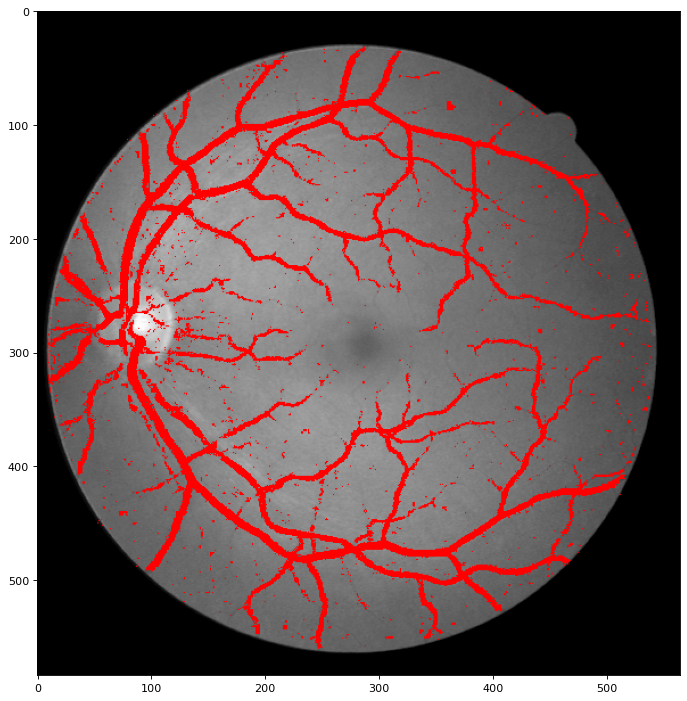

Accuracy score: 0.9293751334659615

F1 score: 0.7214467023441186

Confusion matrix:

     t/p      0     1 
        0 1141835 45710 
        1 50531 124631 
Sensivity: 0.7115184800356241
Specificity: 0.9615088270339229


(0.929, 0.721, 1141835, 45710, 50531, 124631)

In [10]:
def load_images():
    paths = [f"{PATH}/{path}" for path in sorted(listdir(PATH))][14:]
    return [Preprocess.img_processing(np.asarray(Image.open(path).convert('RGB'))[:, :, 1])
            for path in paths]

def load_masks():
    paths = [f"{MASK_PATH}/{path}" for path in sorted(listdir(MASK_PATH))][14:]
    return [np.asarray(Image.open(path).convert('L')) > 100 for path in paths]

IMAGES_test = load_images()
MASKS_test = load_masks()

conv_features_test = [pd.DataFrame(np.array(
    [cv2.filter2D(img, -1, individual[i*k_len:(i+1)*k_len].reshape((k_size, k_size)))[mask]
     for i in range(n_kernels)]
).T)
    for img, mask in zip(IMAGES_test, MASKS_test)]

conv_features_test = pd.concat(conv_features_test, axis=0)
conv_features_test.columns = ['k1', 'k2']

extra_features = {'train': conv_features, 'test': conv_features_test}
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=extra_features, plot_once=True, channels=(1, 2), recurrence=False)

### Clasificador utilizando únicamente la intensidad de gris en el canal verde

In [11]:
y_train, y_test = get_labels('../')

In [55]:
green_channel_train = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES, MASKS)] for item in sublist]
)
green_channel_train.index = y_train.index
green_channel_test = pd.DataFrame(
    [item for sublist in [img[mask].ravel().tolist() for img, mask in zip(IMAGES_test, MASKS_test)] for item in sublist]
)
green_channel_test.index = y_test.index

In [56]:
display(green_channel_train)

0
0        7
1        7
2        7
3       24
4       24
...     ..
226537  10
226538   6
226539  18
226540   5
226541   5

[3178299 rows x 1 columns]

In [57]:
features = {
    'x_train': green_channel_train, 'x_test': green_channel_test,
    'y_train': y_train.reset_index(drop=True), 'y_test': y_test.reset_index(drop=True)
}

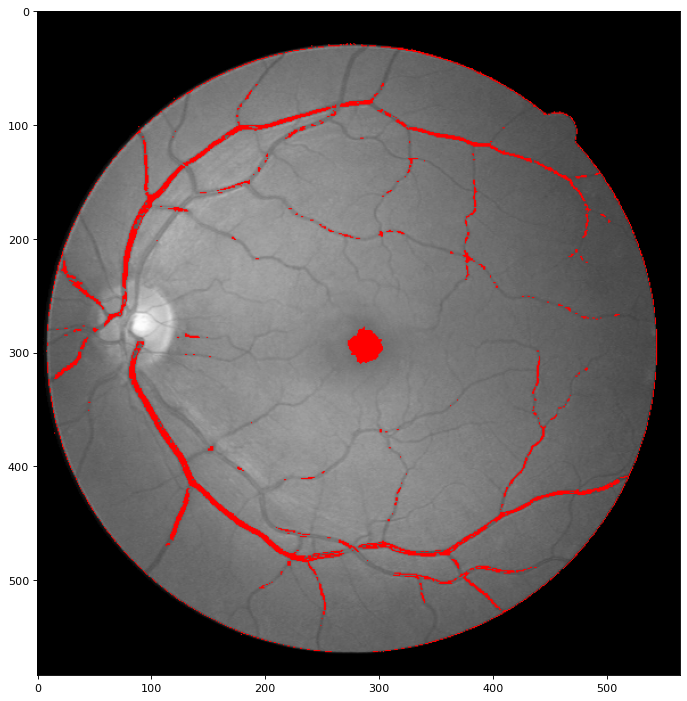

Accuracy score: 0.8826350785605416

F1 score: 0.250325774123691

Confusion matrix:

     t/p      0     1 
        0 1176071 11474 
        1 148460 26702 
Sensivity: 0.15244173964672703
Specificity: 0.9903380503475657


(0.883, 0.25, 1176071, 11474, 148460, 26702)

In [58]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

### Resultados convolucion

Green channel


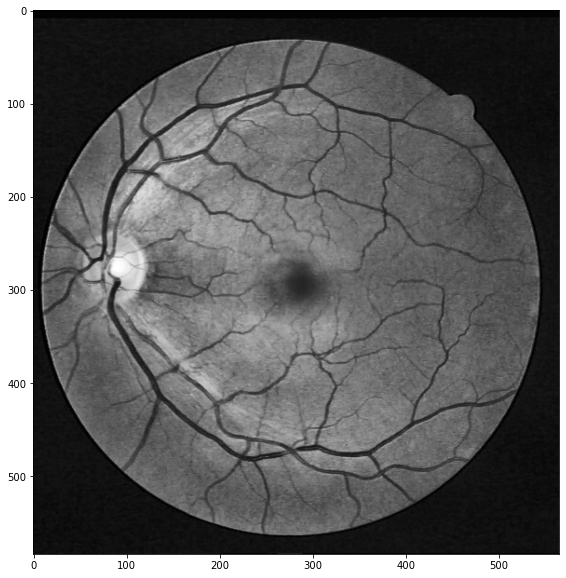


 Convolved images


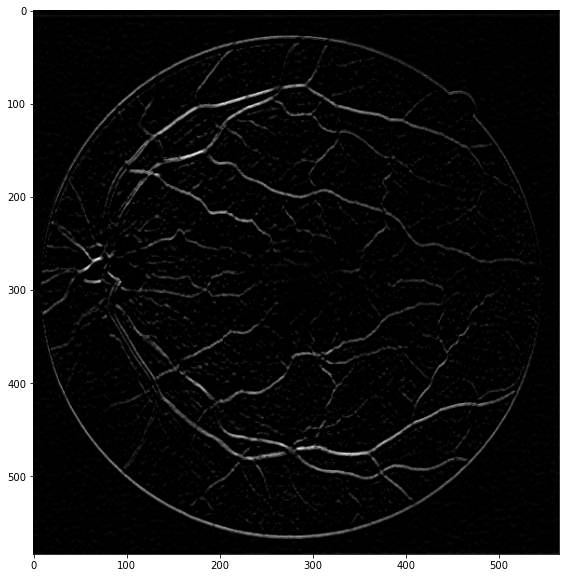

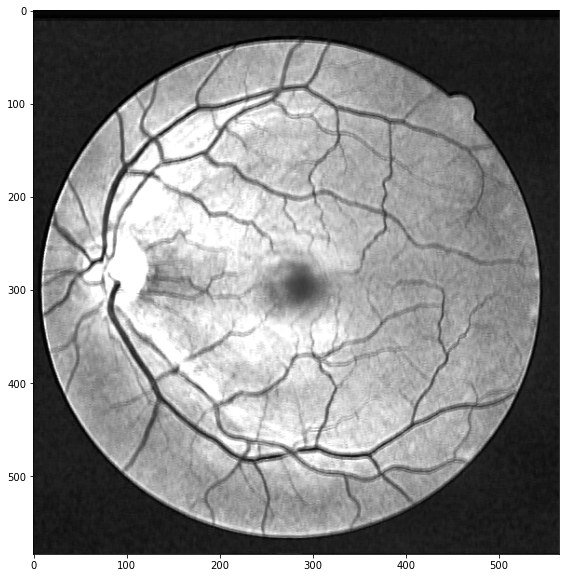

In [66]:
import numpy as np
import pickle


path = 'convolution/outputs/16477813803335671_300'
with open(f'{path}/population.pkl', 'rb') as handle:
    kernels = pickle.load(handle)
population, fitness = kernels['population'], kernels['fitness']
individual = population[np.argmax(fitness), :]
kernel_list = [population[np.argmax(fitness), k:k+9] for k in range(0, len(individual), 9)]

PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
path = PATH + '/35_training.tif'

from os import listdir
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from preprocess.preprocess import Preprocess

img = Preprocess.img_processing(np.asarray(Image.open(path).convert('RGB'))[:, :, 1])
img_convolved = [cv2.filter2D(img, -1, k) for k in kernel_list]
import matplotlib.pyplot as plt
from PIL import Image
from convolution.fitness import IMAGES

im_list = [Image.fromarray(np.uint8(im)) for im in img_convolved]

print('Green channel')
plt.figure(figsize=(18, 10))
plt.imshow(img, cmap='gray')
plt.show()

print('\n Convolved images')
for im in im_list:
    plt.figure(figsize=(18, 10))
    plt.imshow(im, cmap='gray')
    plt.show()

In [67]:
features = {'x_train': extra_features['train'], 'x_test': extra_features['test'], 'y_train': y_train, 'y_test': y_test}

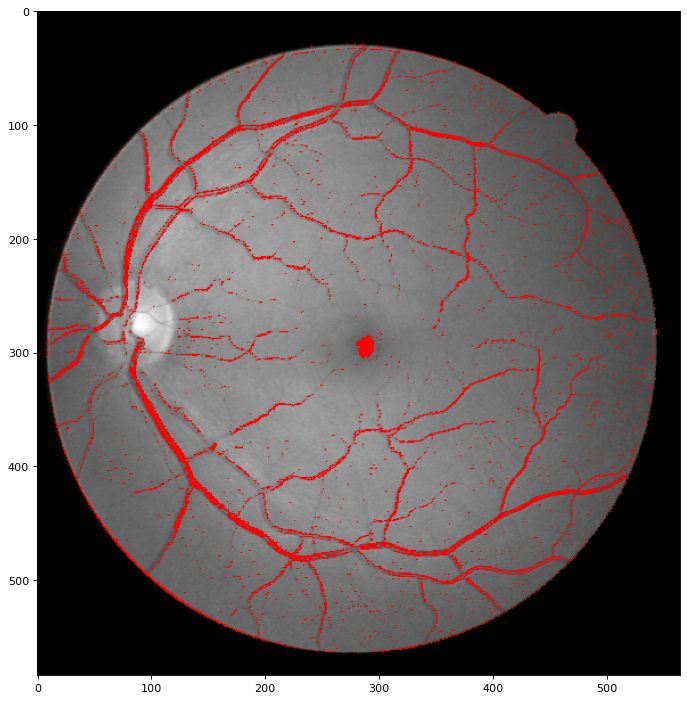

Accuracy score: 0.891657561016418

F1 score: 0.3863027022982629

Confusion matrix:

     t/p      0     1 
        0 1168601 18944 
        1 128695 46467 
Sensivity: 0.26528014066977995
Specificity: 0.9840477624005827


(0.892, 0.386, 1168601, 18944, 128695, 46467)

In [68]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

## Combinación de resultados

In [69]:
features = {
    'x_train': pd.concat([extra_features['train'].reset_index(drop=True), green_channel_train.reset_index(drop=True)], axis=1),
    'x_test': pd.concat([extra_features['test'].reset_index(drop=True), green_channel_test.reset_index(drop=True)], axis=1),
    'y_train': y_train.reset_index(drop=True),
    'y_test': y_test.reset_index(drop=True)
}

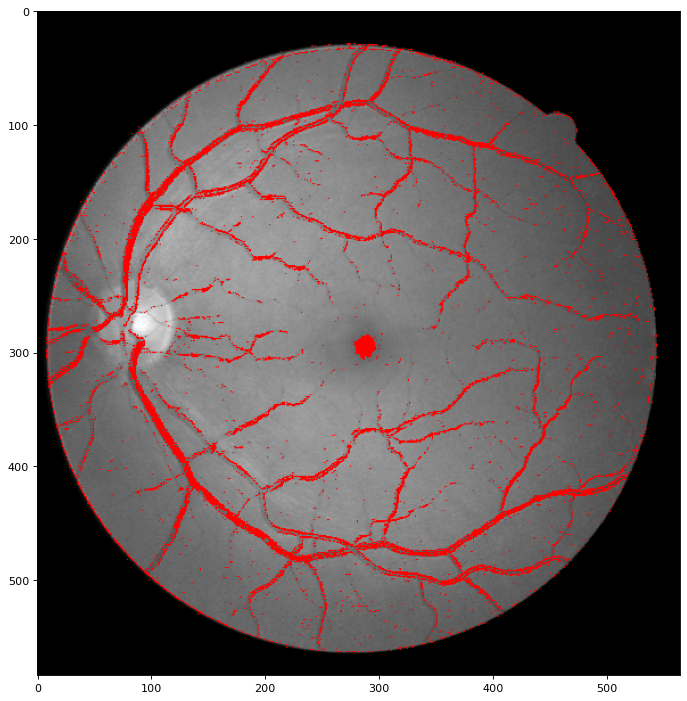

Accuracy score: 0.89565988873617

F1 score: 0.44950771815848267

Confusion matrix:

     t/p      0     1 
        0 1162471 25074 
        1 117111 58051 
Sensivity: 0.33141320606067526
Specificity: 0.9788858527466328


(0.896, 0.45, 1162471, 25074, 117111, 58051)

In [70]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

## Ejecución con 6 núcleos y lightGBM

#### PARAMETERS

Population size: 50

k (tournament selection): 3

alpha (recombination): 0.6

sigma (mutation): 0.4

Mutation probability: 0.05
Recombination probability: 0.2

#### BEST RESULT

Fitness: 0.5421821429908591

Kernels: 
[ 0.57824393  0.82038373  0.07099995  0.2528948   0.18846335  0.46447459
 -0.72705374  0.0833359  -0.32927405 -0.16025841 -0.13966269  0.70875129
 -0.12826092 -0.14080143  0.08264676  0.51256516 -0.46738081  0.11180725
 -0.62229015  0.49288682 -0.04135274 -0.34163865  0.05578874  0.4875621
  0.04538844  0.43100785 -0.33362834  0.32470968  0.3757467   0.41038545
 -0.28575864 -0.03260348 -0.26210066  0.14889375  0.1512707  -0.4361889
  0.01893669 -0.07000617  0.13068801 -0.16329735 -0.19668283  0.0157142
  0.01101857  0.92830659  0.52989309 -0.26713482  0.14623634  0.04371852
  0.63413525  0.46081399 -0.18370832  0.41113241 -0.01074039 -0.57143851]

In [98]:
with open(r'/home/fer/Drive/Estudios/Master-IA/TFM/lbp-pyramid/convolution/outputs/16486911215483892_lightGBM/backup.pkl', 'rb') as f:
    results = pickle.load(f)

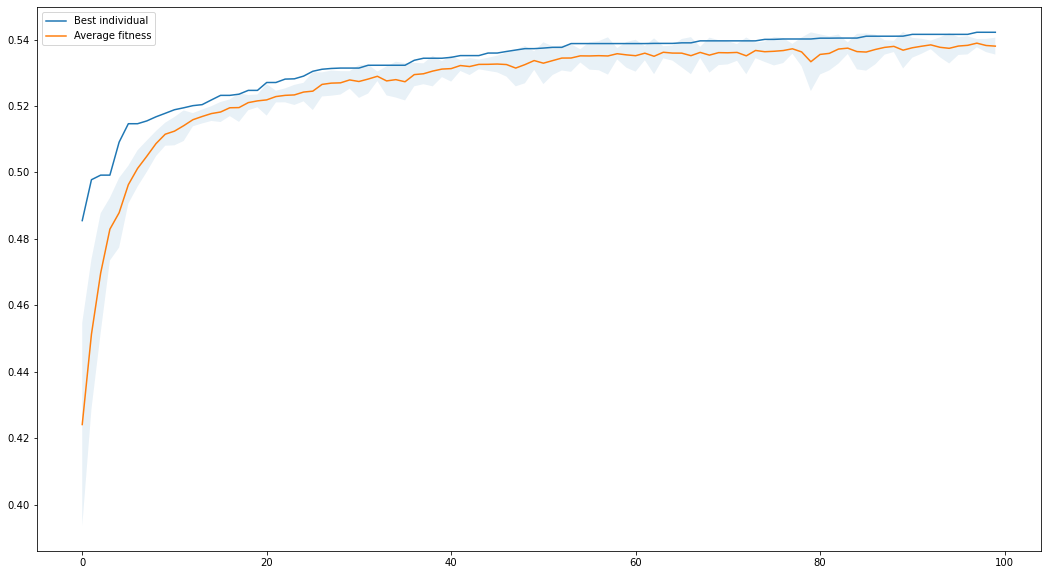

In [99]:
plt.figure(figsize=(18, 10))
#if plot == 'log':
"""
plt.yscale('log', base=10)
delta = 1 - np.min(results[1])
if delta > 0:
    results[0] += delta
    results[1] += delta"""
plt.plot(results[0], label='Best individual')
plt.plot(results[1], label='Average fitness')
plt.fill_between(
    range(len(results[0])),
    np.array(results[1]) - np.array(results[2]),
    np.array(results[1]) + np.array(results[2]),
    alpha=.1
)
plt.legend(loc="upper left")
plt.show()

In [84]:
kernels = "0.57824393 0.82038373 0.07099995 0.2528948 0.18846335 0.46447459 -0.72705374 0.0833359 -0.32927405 -0.16025841 -0.13966269 0.70875129 -0.12826092 -0.14080143 0.08264676 0.51256516 -0.46738081 0.11180725 -0.62229015 0.49288682 -0.04135274 -0.34163865 0.05578874 0.4875621 0.04538844 0.43100785 -0.33362834 0.32470968 0.3757467 0.41038545 -0.28575864 -0.03260348 -0.26210066 0.14889375 0.1512707 -0.4361889 0.01893669 -0.07000617 0.13068801 -0.16329735 -0.19668283 0.0157142 0.01101857 0.92830659 0.52989309 -0.26713482 0.14623634 0.04371852 0.63413525 0.46081399 -0.18370832 0.41113241 -0.01074039 -0.57143851".split(' ')
kernels = np.array([float(k) for k in kernels])
kernels

array([ 0.57824393,  0.82038373,  0.07099995,  0.2528948 ,  0.18846335,
        0.46447459, -0.72705374,  0.0833359 , -0.32927405, -0.16025841,
       -0.13966269,  0.70875129, -0.12826092, -0.14080143,  0.08264676,
        0.51256516, -0.46738081,  0.11180725, -0.62229015,  0.49288682,
       -0.04135274, -0.34163865,  0.05578874,  0.4875621 ,  0.04538844,
        0.43100785, -0.33362834,  0.32470968,  0.3757467 ,  0.41038545,
       -0.28575864, -0.03260348, -0.26210066,  0.14889375,  0.1512707 ,
       -0.4361889 ,  0.01893669, -0.07000617,  0.13068801, -0.16329735,
       -0.19668283,  0.0157142 ,  0.01101857,  0.92830659,  0.52989309,
       -0.26713482,  0.14623634,  0.04371852,  0.63413525,  0.46081399,
       -0.18370832,  0.41113241, -0.01074039, -0.57143851])

In [85]:
k_size = 3
k_len = 9
n_kernels = 6

conv_features = [pd.DataFrame(np.array(
    [cv2.filter2D(img, -1, kernels[i*k_len:(i+1)*k_len].reshape((k_size, k_size)))[mask]
     for i in range(n_kernels)]
).T)
    for img, mask in zip(IMAGES, MASKS)]

conv_features = pd.concat(conv_features, axis=0)
conv_features.columns = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6']
conv_features

k1  k2  k3  k4   k5  k6
0         0  12   5   4   86   0
1         0  16   6   4   92   0
2         0  20  13   0  104   0
3         0  15  20   4  110   0
4         0  16   8   4  108   8
...     ...  ..  ..  ..  ...  ..
226537  141  35   0  92    7  13
226538  144  37   0  94   10   0
226539  137  18   0  88    6   2
226540  115  13   0  70    6   0
226541   88  20   0  61    9   0

[3178299 rows x 6 columns]

In [88]:
from main import get_channel_features, get_labels
import pandas as pd

df_train, _ = get_channel_features('../', lbp_version=['riu', 'var'], channels=(1, 2))
y_train, _ = get_labels('../')

df_train = pd.concat([df_train, conv_features], axis=1)

features = {'x_train': df_train, 'x_test': None, 'y_train': y_train, 'y_test': None}

In [89]:
test_features(features, verbose=True)

Accuracy score: 0.9400621888174586

F1 score: 0.719579843471097

Confusion matrix:

     t/p      0     1 
        0 588220 17089 
        1 23757 52407 
Sensivity: 0.6880809831416417
Specificity: 0.971768138256659
-------------------------------------
Accuracy score: 0.9210297274250934

F1 score: 0.6655042283693067

Confusion matrix:

     t/p      0     1 
        0 573032  9773 
        1 43941 53434 
Sensivity: 0.5487445442875482
Specificity: 0.98323109788008
-------------------------------------
Accuracy score: 0.9358191371827296

F1 score: 0.7412557669701034

Confusion matrix:

     t/p      0     1 
        0 575920 17524 
        1 26277 62741 
Sensivity: 0.7048125098294727
Specificity: 0.9704706762558893
-------------------------------------
Accuracy score: 0.9396694239186709

F1 score: 0.6846317667048522

Confusion matrix:

     t/p      0     1 
        0 594361 12813 
        1 28206 44524 
Sensivity: 0.612182043173381
Specificity: 0.9788973177375843
-----------------------

{'acc': 0.9283137180803956, 'f1': 0.6910813793451016}

Green channel


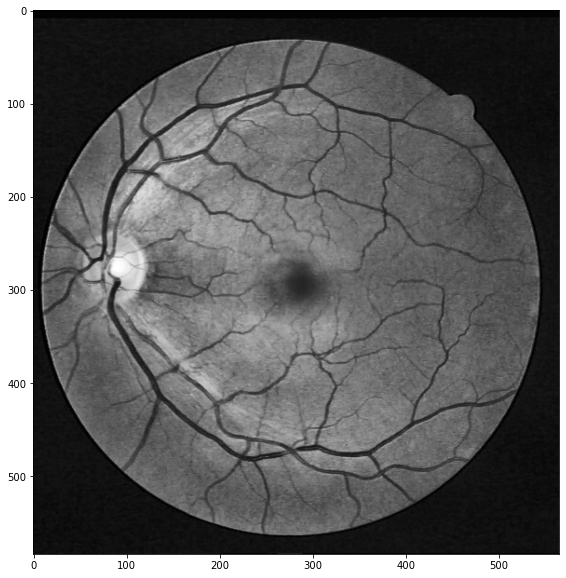


 Convolved images


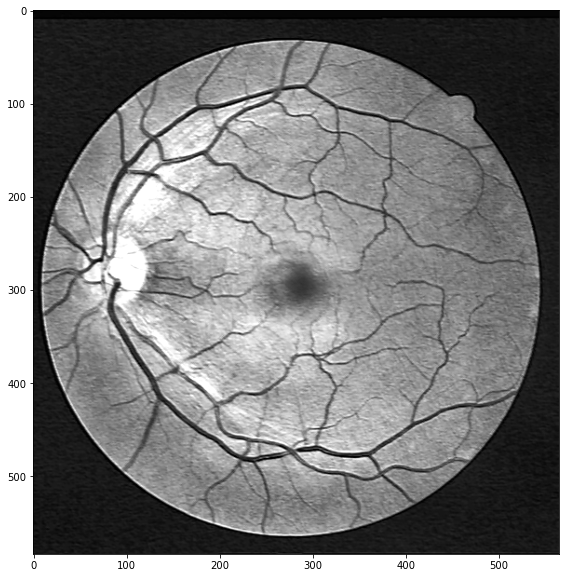

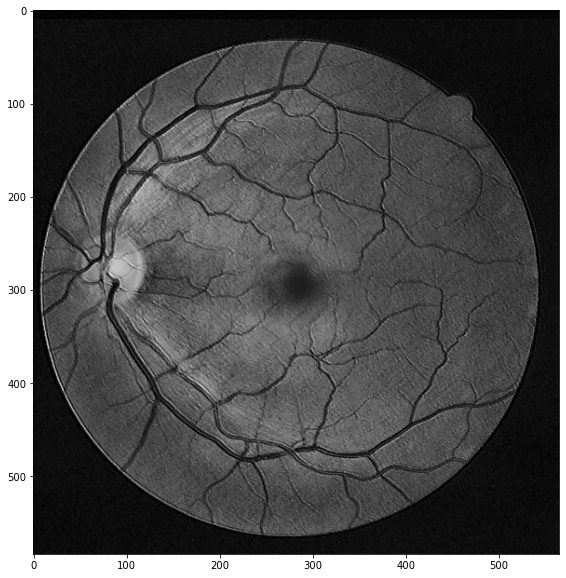

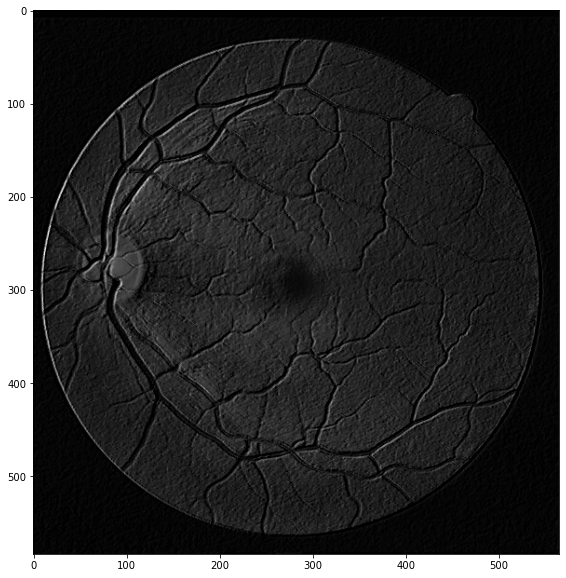

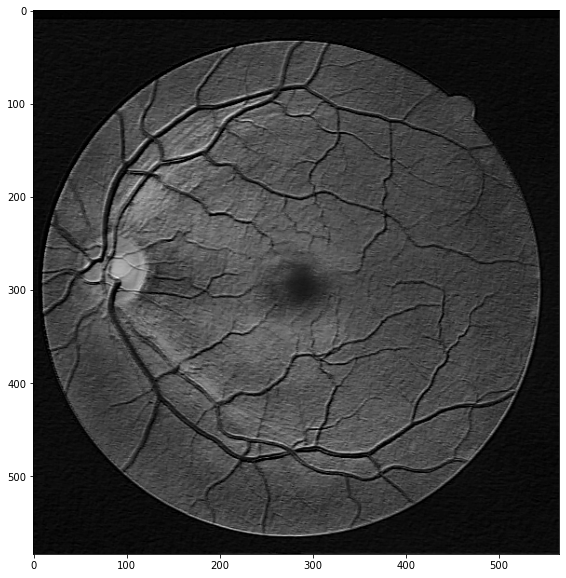

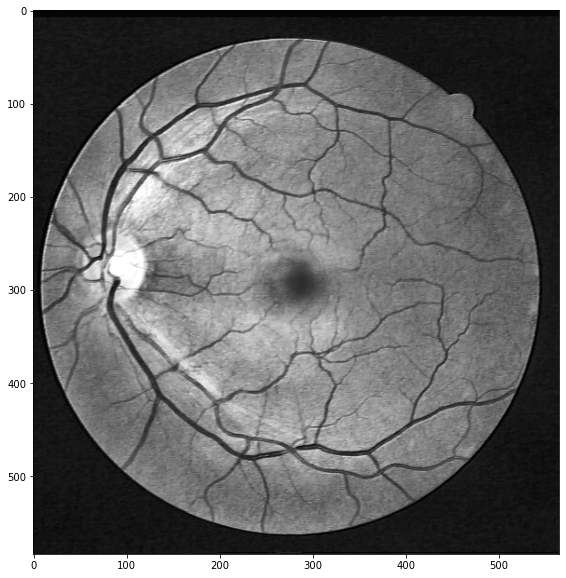

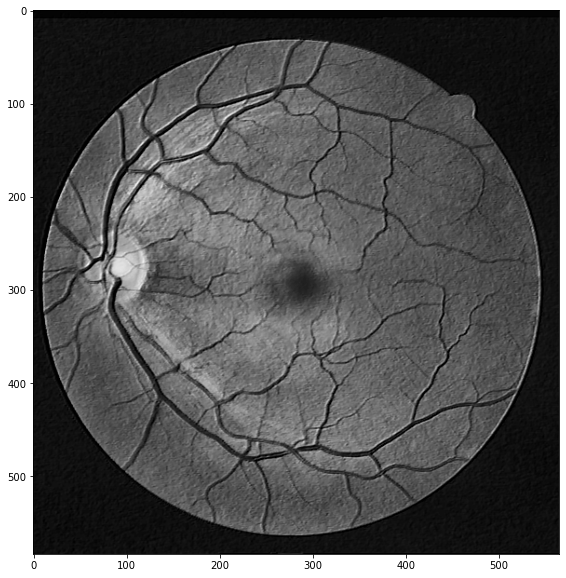

In [90]:
PATH = r'/home/fer/Drive/Estudios/Master-IA/TFM/dataset/DRIVE/training/images'
path = PATH + '/35_training.tif'
img = Preprocess.img_processing(np.asarray(Image.open(path).convert('RGB'))[:, :, 1])
img_convolved = [cv2.filter2D(img, -1, kernels[i*k_len:(i+1)*k_len].reshape((k_size, k_size)))
     for i in range(n_kernels)]
import matplotlib.pyplot as plt
from PIL import Image
from convolution.fitness import IMAGES

im_list = [Image.fromarray(np.uint8(im)) for im in img_convolved]

print('Green channel')
plt.figure(figsize=(18, 10))
plt.imshow(img, cmap='gray')
plt.show()

print('\n Convolved images')
for im in im_list:
    plt.figure(figsize=(18, 10))
    plt.imshow(im, cmap='gray')
    plt.show()

In [92]:
conv_features_test = [pd.DataFrame(np.array(
    [cv2.filter2D(img, -1, kernels[i*k_len:(i+1)*k_len].reshape((k_size, k_size)))[mask]
     for i in range(n_kernels)]
).T)
    for img, mask in zip(IMAGES_test, MASKS_test)]

conv_features_test = pd.concat(conv_features_test, axis=0)
conv_features_test.columns = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6']

extra_features = {'train': conv_features, 'test': conv_features_test}
features = {'x_train': extra_features['train'], 'x_test': extra_features['test'], 'y_train': y_train, 'y_test': y_test}

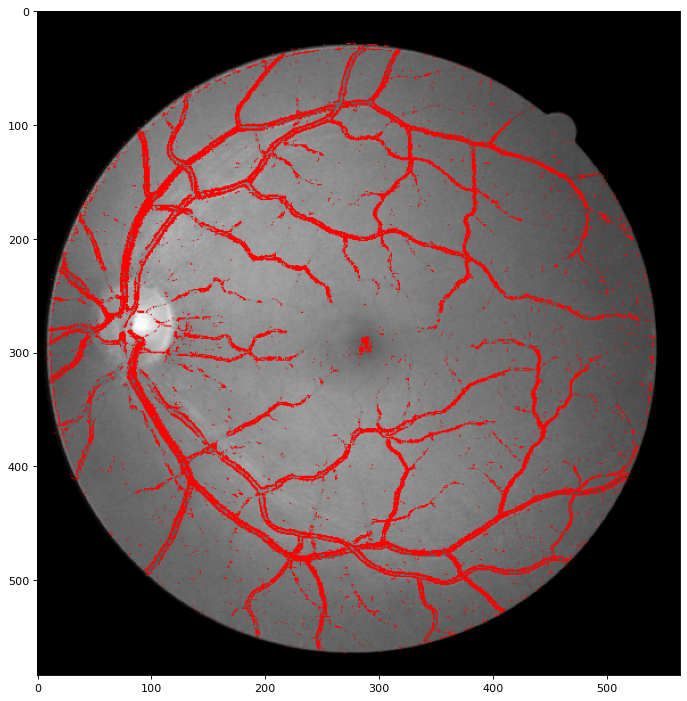

Accuracy score: 0.9155665891493916

F1 score: 0.6149356430010509

Confusion matrix:

     t/p      0     1 
        0 1155777 31768 
        1 83290 91872 
Sensivity: 0.5244973224786198
Specificity: 0.9732490137215852


(0.916, 0.615, 1155777, 31768, 83290, 91872)

In [93]:
main(lgb='Num', features=features, plot_once=True, recurrence=False)

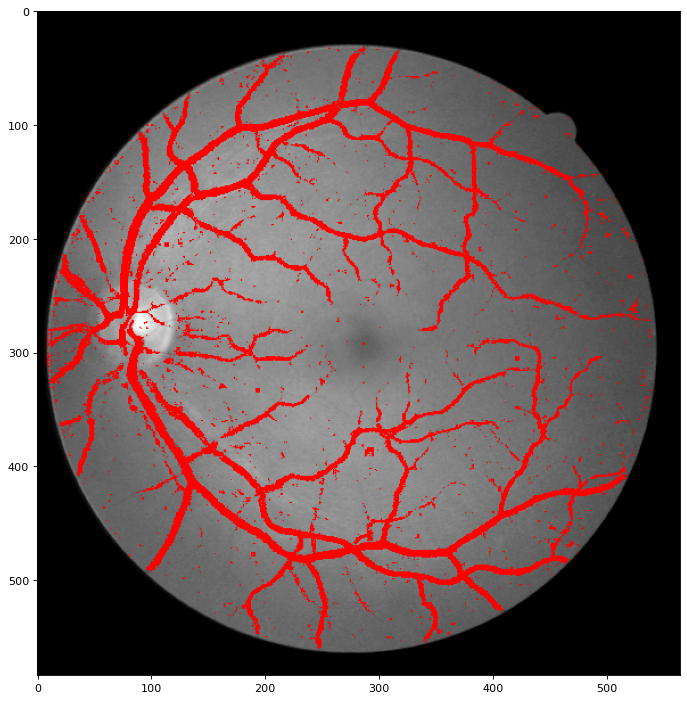

Accuracy score: 0.9307855613862701

F1 score: 0.7283790983311496

Confusion matrix:

     t/p      0     1 
        0 1141925 45620 
        1 48699 126463 
Sensivity: 0.7219773695207865
Specificity: 0.9615846136356938


(0.931, 0.728, 1141925, 45620, 48699, 126463)

In [94]:
main(lgb='Num', all_lbp=['riu', 'var'], extra_features=extra_features, plot_once=True, channels=(1, 2), recurrence=False)

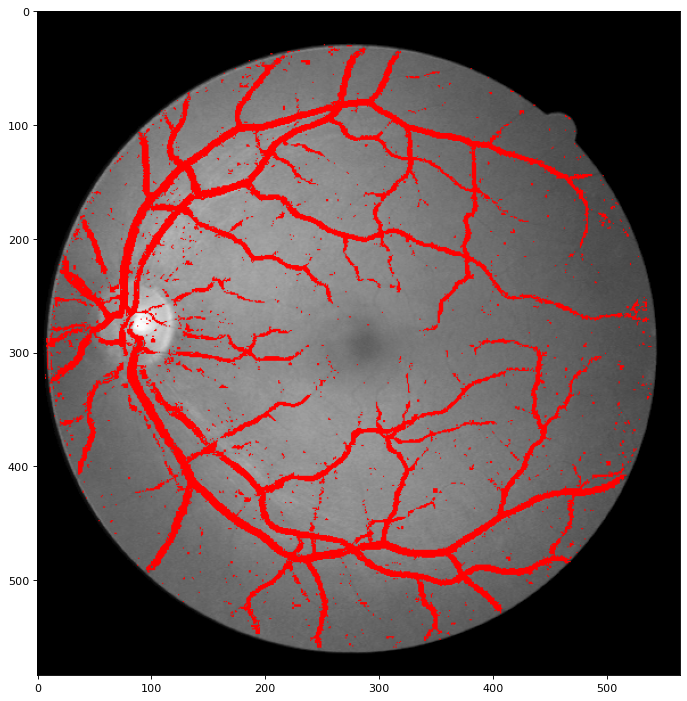

Accuracy score: 0.9292555186111174

F1 score: 0.7211952246541113

Confusion matrix:

     t/p      0     1 
        0 1141617 45928 
        1 50476 124686 
Sensivity: 0.7118324750802114
Specificity: 0.9613252550429668


(0.929, 0.721, 1141617, 45928, 50476, 124686)

In [95]:
main(lgb='Num', all_lbp=['riu', 'var'], plot_once=True, channels=(1, 2), recurrence=False)